# Final Project - Basics of deep learning
Hello dear students,<br> This is the template notebook. Please copy it into your drive.

---
<br>

### Name and ID:
Student 1: Stav Elizur
<br>
Student 2: Tommy Afek

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/20733/logos/header.png?t=2020-05-14-08-44-45">

# Utils

## Import Libraries

In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import load_img
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten
from keras.preprocessing.image import ImageDataGenerator
import pickle
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.applications.xception import Xception, preprocess_input
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1DS_5kLbzYYzMWtp1WP3x_hxtRBhroJID

!gdown --id 1DqidwA4S0rkwLlI6-A6-7vgHYJNoEfhH
!unzip /content/Explainer_final_project.zip

## Dataset
Cars196 - 196 different classes of vehicles

### Download Data
Load the cars196 dataset from tensorflow datasets

In [8]:
%%capture
cars196, ds_info = tfds.load('Cars196', as_supervised=True, shuffle_files=True,with_info=True)

Dictionary of the labels - maps between the label (int) number and the vehicle model (str)

In [ ]:
label_dic = pd.read_csv('/content/labels_dic.csv', header=None, dtype={0: str}).set_index(0).squeeze().to_dict()

### Function - Plot Single Example
This function receives an image and a label and it will display it on a plot

In [ ]:
def plot_single_example(image, label, label_dic=label_dic):
  car_model_by_label = label_dic[str(label)]
  plt.title(f'Image Label: {car_model_by_label} ({label})')
  plt.imshow(image)
  print(image.shape)


##Hyper parameters

In [6]:
INPUT_WIDTH = 170
INPUT_LENGTH = 170
BATCH_SIZE = 32
LEARNING_RATE=0.001
NUM_OF_CLASSES = 196
NUM_OF_EPOCHS = 10
NUM_OF_NEIGHBORS = 5

# Data Preprocessing

### Split Dataset
Train set contains 8041 examples<br>
Test set contains 8144 examples<br>
**It is allowed to change the ratio between the data sets.**


In [ ]:
cars_train=cars196['train']
cars_test=cars196['test']

Rearrange the ratio of our dataset

In [ ]:
cars = cars_train.concatenate(cars_test)

cars_train = cars.take(14585)
cars = cars.skip(14585)
cars_test = cars.take(1600)

print(cars_train.cardinality().numpy())
print(cars_test.cardinality().numpy())

14585
1600


Create preprocessing functions and generate more images with data augmentation logic

In [ ]:
def train_preprocessing(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    image = tf.image.resize(image, [INPUT_LENGTH, INPUT_WIDTH])
    label = tf.one_hot(label, NUM_OF_CLASSES)

    return image, label

def train_flip_right_left(image, label):
    image = tf.image.random_flip_left_right(image)

    return image, label

def train_contrast(image, label):
    image = tf.image.random_contrast(image, lower=0.0, upper=1.0)

    return image, label

def test_preprocessing(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    image = tf.image.resize(image, [INPUT_LENGTH, INPUT_WIDTH])
    label = tf.one_hot(label, NUM_OF_CLASSES)

    return image, label

def get_dataset(cars_train, cars_test):
    train_dataset = cars_train.map(train_preprocessing).shuffle(1000)
    train_dataset = train_dataset.concatenate(cars_train.map(train_preprocessing).map(train_flip_right_left)).shuffle(1000)
    train_dataset = train_dataset.concatenate(cars_train.map(train_preprocessing).map(train_contrast)).shuffle(1000)
    test_dataset = cars_test.map(test_preprocessing)
    
    return train_dataset, test_dataset

cars_train, cars_test = get_dataset(cars_train, cars_test)

print(cars_train.cardinality().numpy())
print(cars_test.cardinality().numpy())

43755
1600


### Example
Random example from the data set

(170, 170, 3)


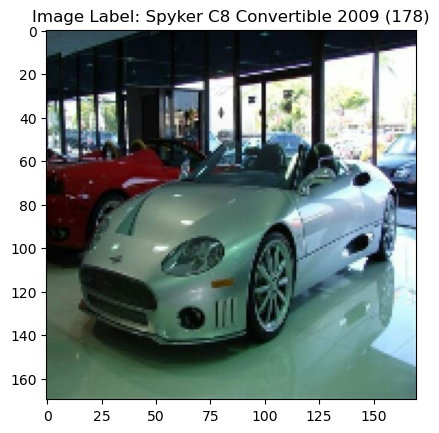

In [ ]:
image, label = cars_train.as_numpy_iterator().next()
plot_single_example(image, label.argmax())

# Transfer Learning

Imports The Xception Model

In [3]:
class TransferLearningModel():
  def __init__(self, input_length, input_width, num_of_unfrozen_layers):
    self.base_model = Xception(weights='imagenet',include_top=False, input_shape=(input_length, input_width, 3))
    self.base_model.trainable = False

    for layer in self.base_model.layers[:-num_of_unfrozen_layers]:
        layer.trainable=True

## Add layers of our own
We add dense layers so that the model can learn more complex functions and classify for better results. 

Create the model according to the input and output layers

In [ ]:
class TransferLearningModel(TransferLearningModel):
  def BestModelGenerate(self):  
    addition_layers = self.base_model.output
    addition_layers = GlobalAveragePooling2D(name='flatten')(addition_layers)
    addition_layers = Dropout(0.5)(addition_layers)
    output_layer = Dense(196,activation='softmax')(addition_layers)
    self.model = Model(inputs=self.base_model.input, outputs=output_layer)

## Compiling the model
Now a model has been created based on our architecture 🏆

In [ ]:
class TransferLearningModel(TransferLearningModel):  
  def Compile(self, learning_rate=0.001):
    self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

## Training our model on the Training set

In [ ]:
class TransferLearningModel(TransferLearningModel):  
  def Train(self, batch_size, num_of_epoch, training_set, test_Set):
    self.history = self.model.fit(training_set.batch(batch_size), validation_data=test_Set.batch(batch_size), batch_size=batch_size, epochs=num_of_epoch)

## Model Results

In [ ]:
class TransferLearningModel(TransferLearningModel):
  def PredictingTestResults(self, test_set):
    predictions = np.array([]) 
    labels =  np.array([])

    num_of_cars = test_set.cardinality().numpy()
    cars_it = test_set.as_numpy_iterator()
    for car_index in range(num_of_cars):
      image, label = cars_it.next()
      prediction = self.model.predict(np.expand_dims([image],axis=-1))
      predictions = np.concatenate([predictions, [prediction.argmax()]])
      labels = np.concatenate([labels,[label.argmax()]])

    return labels, predictions

## Model Performance Evaluation

### Visualization of the Loss training VS validation

In [ ]:
class TransferLearningModel(TransferLearningModel):
  def ShowLossTrainingVsValidation(self):
    from matplotlib import pyplot as plt
    plt.plot(self.history.history['loss'])
    plt.plot(self.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### Visualization of the Accuracy training VS validation

In [ ]:
class TransferLearningModel(TransferLearningModel):
  def ShowAccuracyTrainingVsValidation(self):
    from matplotlib import pyplot as plt
    plt.plot(self.history.history['accuracy'])
    plt.plot(self.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### Visualization of the Accuracy Score

In [ ]:
class TransferLearningModel(TransferLearningModel):
  def PrintAccuracyScore(self, labels, predictions):
    from sklearn.metrics import accuracy_score

    accuracy = accuracy_score(labels, predictions)
    print(f'Accuracy: {round(accuracy*100)}%')

### Visualization of the Balanced Accuracy Score

In [ ]:
class TransferLearningModel(TransferLearningModel):
  def PrintBalancedAccuracyScore(self, labels, predictions):
    from sklearn.metrics import balanced_accuracy_score
    
    bal_acc = balanced_accuracy_score(labels, predictions)
    print(f'Balanced Accuracy: {round(bal_acc*100)}%')

### Printing the confusion matrix

In [ ]:
class TransferLearningModel(TransferLearningModel):
  def PrintConfusionMatrix(self, labels, predictions):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(labels, predictions)
    print(f'Confusion Matrix:\n\n{cm}')

    return cm

In [ ]:
class TransferLearningModel(TransferLearningModel):
  def PrintConfusionmatrixaAsTable(self, labels, predictions):
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(labels, predictions)
    cmd = ConfusionMatrixDisplay(cm, display_labels=ds_info.features['label'].names)
    cmd.plot()

### Show Classification Report

In [ ]:
class TransferLearningModel(TransferLearningModel):
  def PrintClassificationReport(self, labels, predictions):
    from sklearn.metrics import classification_report
    print(classification_report(labels, predictions, target_names=ds_info.features['label'].names))

##Show all model metrics

In [ ]:
class TransferLearningModel(TransferLearningModel):
  def ShowModelEvaluation(self, labels, predictions):
    self.ShowLossTrainingVsValidation()
    self.ShowAccuracyTrainingVsValidation()
    self.PrintConfusionMatrix(labels, predictions)
    self.PrintConfusionmatrixaAsTable(labels, predictions)
    self.PrintAccuracyScore(labels, predictions)
    self.PrintBalancedAccuracyScore(labels, predictions)
    self.PrintClassificationReport(labels, predictions)

## Save the model

In [ ]:
class TransferLearningModel(TransferLearningModel):  
  def SaveModel(self, path):
    from google.colab import drive
    drive.mount('/content/drive')
    self.model.save(path)

## Load the Transfer Learning model


Load the model according to the id and name

In [4]:
class TransferLearningModel(TransferLearningModel):
  @staticmethod
  def LoadModel(id, name):
    import gdown
    from zipfile import ZipFile
    gdown.download(id=id, output=f'/content/{name}.zip', quiet=False)
    
    zf = ZipFile(f'/content/{name}.zip', 'r')
    zf.extractall('/content/')
    zf.close()

    return tf.keras.models.load_model(f'/content/{name}')

## Experiments

Show how the number of layers and number of neurons in layer affected on the model results

83683744/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 170, 170, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 84, 84, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 84, 84, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                             

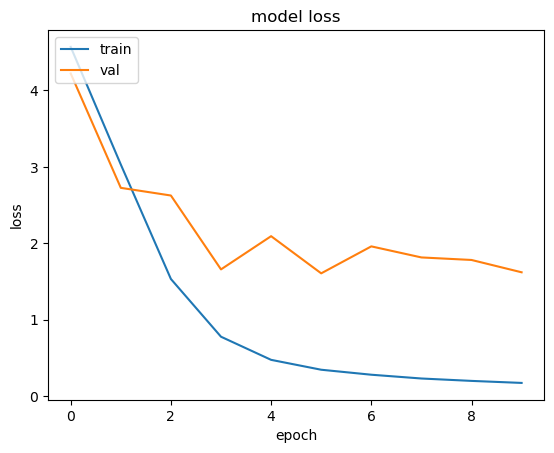

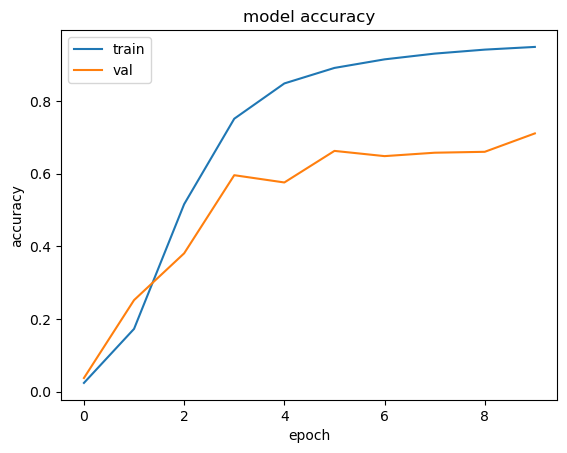

Confusion Matrix:

[[10  0  0 ...  0  0  0]
 [ 0  2  0 ...  0  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ... 11  0  0]
 [ 0  0  0 ...  0  6  0]
 [ 0  0  0 ...  0  0  8]]
Accuracy: 71%
Balanced Accuracy: 71%
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.83      0.91      0.87        11
                                   Acura RL Sedan 2012       1.00      0.40      0.57         5
                                   Acura TL Sedan 2012       0.33      0.40      0.36         5
                                  Acura TL Type-S 2008       0.75      0.75      0.75         8
                                  Acura TSX Sedan 2012       0.56      0.83      0.67         6
                             Acura Integra Type R 2001       0.82      0.90      0.86        10
                              Acura ZDX Hatchback 2012       0.75      0.43      0.55         7
              Aston

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


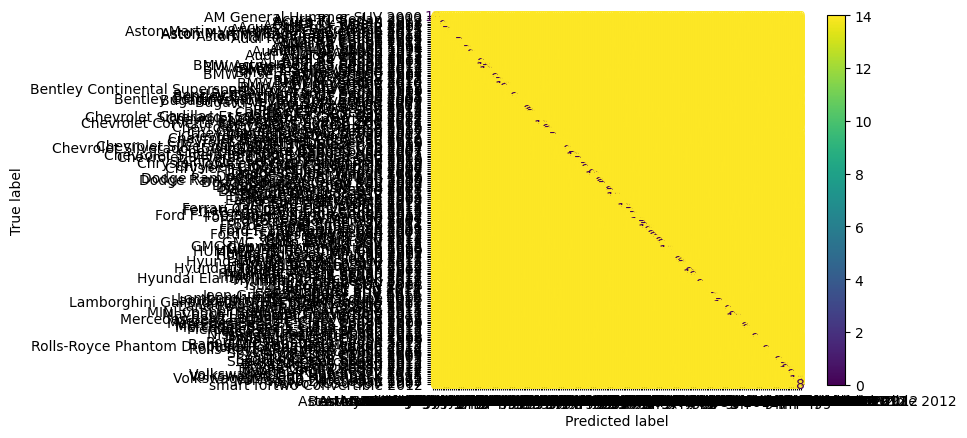

In [ ]:
class TransferLearningModel(TransferLearningModel):  
  def first_experiment(self,
                       training_set,
                       test_set,
                       fully_connected_layers_list,
                       neurons_in_layer_list):
    index_experiment = 1
    for fully_connected_layer in fully_connected_layers_list:
      for neuron_in_layer in neurons_in_layer_list:

        addition_layers = self.base_model.output
        addition_layers = GlobalAveragePooling2D()(addition_layers)

        units = neuron_in_layer
        for fully_con_layer in range(fully_connected_layer):
          addition_layers = Dense(units=units, activation='relu')(addition_layers)
          units = units // 2

        output_layer = Dense(units=NUM_OF_CLASSES, activation='softmax')(addition_layers)

        self.model = Model(inputs=self.base_model.input,outputs=output_layer)
        self.model.summary()

        self.Compile()
        self.Train(BATCH_SIZE, NUM_OF_EPOCHS, training_set.batch(BATCH_SIZE), test_set.batch(BATCH_SIZE))

        labels, predictions = self.PredictingTestResults(test_set)
        self.ShowModelEvaluation(labels, predictions)

        self.SaveModel(f'/content/drive/MyDrive/Google Colab/Final Project Basics/Transfer Learning/Exp1/{index_experiment}')
        index_experiment += 1

transferLearningModel = TransferLearningModel(INPUT_LENGTH, INPUT_WIDTH, 10)
transferLearningModel.first_experiment(cars_train, 
                                       cars_test,
                                       [3],
                                       [120])

Show how the learning rate and batch size and number of epohcs affected on the model results

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 170, 170, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 84, 84, 32)   864         ['input_2[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 84, 84, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

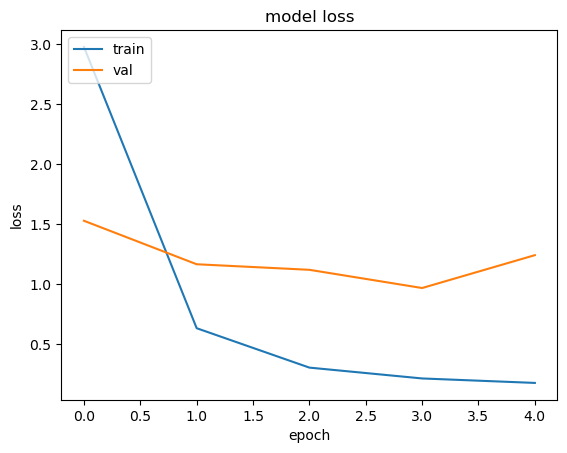

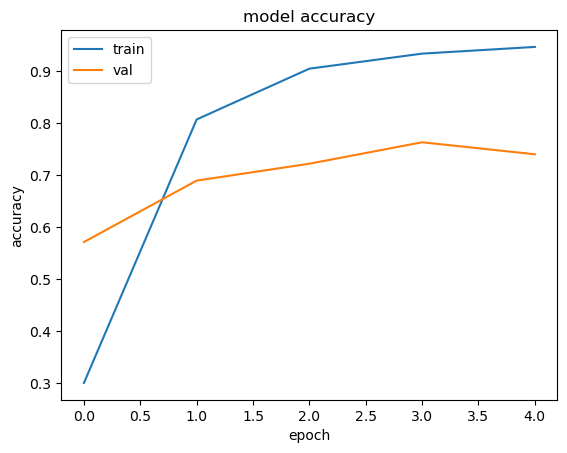

Confusion Matrix:

[[12  0  0 ...  0  0  0]
 [ 0  3  0 ...  0  0  0]
 [ 0  0  5 ...  0  0  0]
 ...
 [ 0  0  0 ... 11  0  0]
 [ 0  0  0 ...  0  7  0]
 [ 0  0  0 ...  0  0  7]]
Accuracy: 74%
Balanced Accuracy: 75%
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.75      1.00      0.86        12
                                   Acura RL Sedan 2012       0.60      0.60      0.60         5
                                   Acura TL Sedan 2012       0.71      1.00      0.83         5
                                  Acura TL Type-S 2008       0.38      0.75      0.50         8
                                  Acura TSX Sedan 2012       1.00      0.20      0.33         5
                             Acura Integra Type R 2001       0.89      0.89      0.89         9
                              Acura ZDX Hatchback 2012       0.83      0.71      0.77         7
              Aston

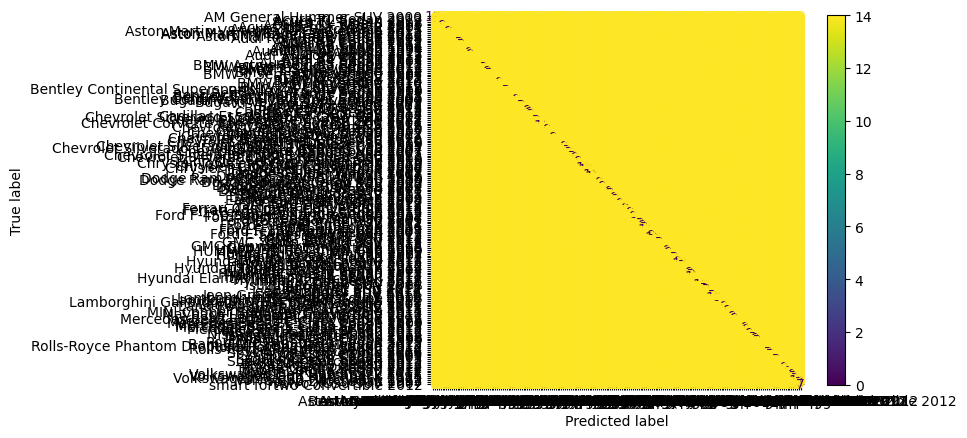

In [ ]:
class TransferLearningModel(TransferLearningModel):  
  def second_experiment(self,
                        training_set,
                        test_set,
                        learning_rates,
                        batch_sizes,
                        numbers_of_epochs):
    
    index_experiment = 1
    for learning_rate in learning_rates:
      for batch_size in batch_sizes:
        for numbers_of_epoch in numbers_of_epochs:
          addition_layers=self.base_model.output
          addition_layers = GlobalAveragePooling2D()(addition_layers)

          addition_layers = Dropout(0.5)(addition_layers)
          output_layer = Dense(NUM_OF_CLASSES,activation='softmax')(addition_layers)

          self.model = Model(inputs=self.base_model.input, outputs=output_layer)
          self.model.summary()
          
          self.Compile()
          self.Train(batch_size, numbers_of_epoch, training_set.batch(batch_size), test_set.batch(batch_size))

          labels, predictions = self.PredictingTestResults(test_set)
          self.ShowModelEvaluation(labels, predictions)

          self.SaveModel(f'/content/drive/MyDrive/Google Colab/Final Project Basics/Transfer Learning/Exp2/{index_experiment}')
          index_experiment += 1

transferLearningModel = TransferLearningModel(INPUT_LENGTH, INPUT_WIDTH, 10)
transferLearningModel.second_experiment(cars_train, 
                                        cars_test,
                                        [0.001],
                                        [40],
                                        [5])

Load the model according to the id and name

## Create a TransferLearningModel object and training our model on the Training set

83683744/83683744 [==============================] - 0s 0us/step
Epoch 1/10
1368/1368 [==============================] - 361s 233ms/step - loss: 3.5228 - accuracy: 0.2043 - val_loss: 1.8622 - val_accuracy: 0.4919
Epoch 2/10
1368/1368 [==============================] - 328s 231ms/step - loss: 0.8246 - accuracy: 0.7472 - val_loss: 1.4752 - val_accuracy: 0.6094
Epoch 3/10
1368/1368 [==============================] - 332s 233ms/step - loss: 0.3564 - accuracy: 0.8853 - val_loss: 1.4241 - val_accuracy: 0.6694
Epoch 4/10
1368/1368 [==============================] - 368s 260ms/step - loss: 0.2401 - accuracy: 0.9247 - val_loss: 1.4681 - val_accuracy: 0.6875
Epoch 5/10
1368/1368 [==============================] - 367s 260ms/step - loss: 0.1844 - accuracy: 0.9440 - val_loss: 1.3888 - val_accuracy: 0.6750
Epoch 6/10
1368/1368 [==============================] - 326s 229ms/step - loss: 0.1608 - accuracy: 0.9501 - val_loss: 1.0240 - val_accuracy: 0.7581
Epoch 7/10
1368/1368 [=========================

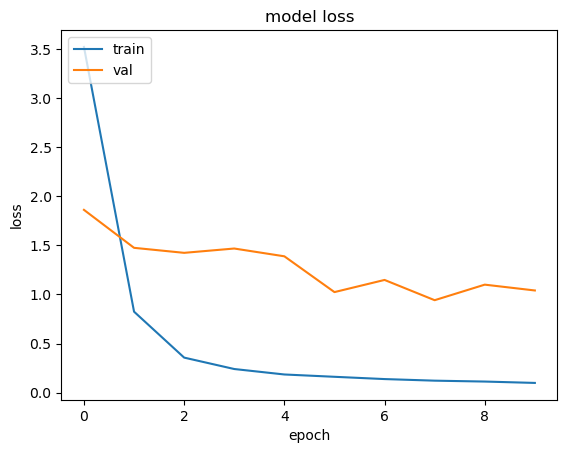

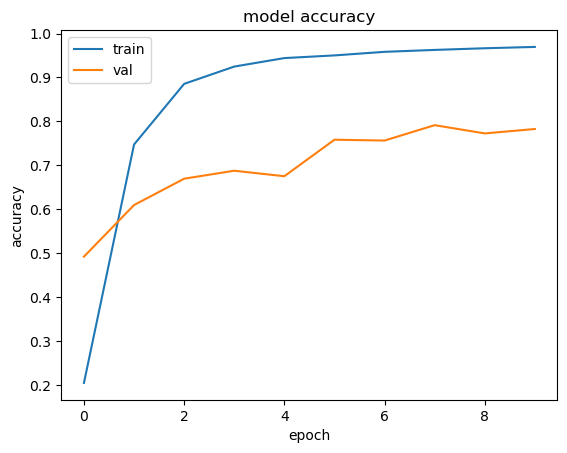

Confusion Matrix:

[[11  0  0 ...  0  0  0]
 [ 0  2  1 ...  0  0  0]
 [ 0  0  4 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0  7  0]
 [ 0  0  0 ...  0  0  8]]
Accuracy: 78%
Balanced Accuracy: 79%
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.92      0.92      0.92        12
                                   Acura RL Sedan 2012       0.67      0.40      0.50         5
                                   Acura TL Sedan 2012       0.57      0.80      0.67         5
                                  Acura TL Type-S 2008       0.86      0.75      0.80         8
                                  Acura TSX Sedan 2012       0.80      0.67      0.73         6
                             Acura Integra Type R 2001       1.00      0.60      0.75        10
                              Acura ZDX Hatchback 2012       0.78      1.00      0.88         7
              Aston

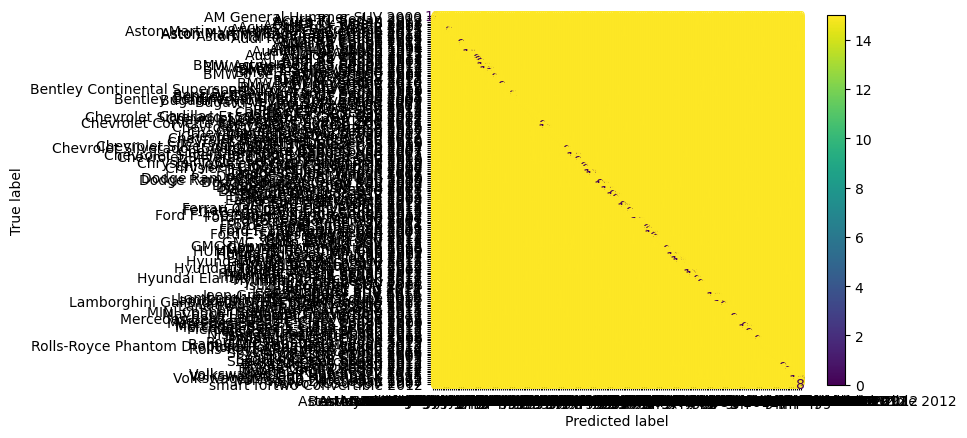

In [ ]:
transfer_learning_model = TransferLearningModel(INPUT_LENGTH, INPUT_WIDTH, 10)

transfer_learning_model.BestModelGenerate()
transfer_learning_model.Compile(LEARNING_RATE)
transfer_learning_model.Train(BATCH_SIZE, NUM_OF_EPOCHS, cars_train, cars_test)
labels, predictions = transfer_learning_model.PredictingTestResults(cars_test)
transfer_learning_model.ShowModelEvaluation(labels, predictions)
transfer_learning_model.SaveModel('/content/drive/MyDrive/Google Colab/Final Project Basics/KNN Classifier Model/TLBestModel')

## Making a single prediction

Downloading...
From: https://drive.google.com/uc?id=1GlSxW6ANqfkao7lkc7vxXaGsTmIln8li
To: /content/TLBestModel.zip
100%|██████████| 197M/197M [00:00<00:00, 209MB/s]


Saving 2012FRD003a_640_01.jpg to 2012FRD003a_640_01 (2).jpg
Saving chevy.jpg to chevy (2).jpg
1/1 [==============================] - 1s 971ms/step
Name of class: Ford Edge SUV 2012


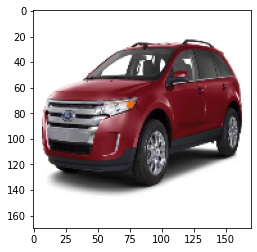

1/1 [==============================] - 0s 28ms/step
Name of class: Chevrolet Cobalt SS 2010


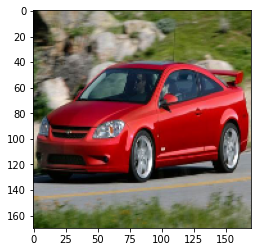

In [9]:
from google.colab import files
from PIL import Image

transfer_learning_id = '1GlSxW6ANqfkao7lkc7vxXaGsTmIln8li'
transfer_learning_name = 'TLBestModel'
transfer_learning_model = TransferLearningModel.LoadModel(transfer_learning_id, transfer_learning_name)
test_images = files.upload()
for imageName in test_images.keys():
    image = tf.cast(Image.open(imageName), tf.float32)
    image /= 255.0
    image = tf.image.resize(image, [INPUT_LENGTH, INPUT_WIDTH])
    result = transfer_learning_model.predict(np.expand_dims([image],axis=-1))
    class_names = ds_info.features['label'].names
    print(f'Name of class: {class_names[np.argmax(result[0], axis=-1)]}') 
    plt.imshow(image)
    plt.show()

# Image Retrieval

## KNN Model from Our best transfer learning Model
Importing the transfer learning model

In [10]:
class KNNClassifierModel():
  def __init__(self, transfer_learning_id, transfer_learning_name): 
    self.transfer_learning_best_model = TransferLearningModel.LoadModel(transfer_learning_id, transfer_learning_name)

### Building the Encoder Model

In [ ]:
class KNNClassifierModel(KNNClassifierModel):
  def BuildEncoder(self): 
    self.encoder=Model(inputs=self.transfer_learning_best_model.input, 
                       outputs=self.transfer_learning_best_model.get_layer('flatten').output)

### Generate predictions of the training

In [ ]:
class KNNClassifierModel(KNNClassifierModel):
  def PredictEncoderResults(self, set):
    predictions = np.array([]) 
    labels =  np.array([])

    x = 1
    num_of_cars = set.cardinality().numpy()
    for images, images_labels in set.batch(BATCH_SIZE):
      prediction = self.encoder.predict(images)
      if len(predictions) == 0:
        predictions = prediction
      else:
        predictions = np.append(predictions, prediction,axis=0)

      for index in range(len(images_labels)):
        labels = np.concatenate([labels,[np.argmax(images_labels[index])]])
      x+=1

    return labels, predictions

## Adding the KNN Model

In [ ]:
class KNNClassifierModel(KNNClassifierModel):
  def AddKNNModel(self, num_of_neighbors, power=2): 
    self.knn = KNeighborsClassifier(n_neighbors=num_of_neighbors, p=power)

Training knn model

In [ ]:
class KNNClassifierModel(KNNClassifierModel):
  def Train(self, labels, encoder_predictions):
    self.history = self.knn.fit(encoder_predictions, labels)

## Genrate the best

In [ ]:
class KNNClassifierModel(KNNClassifierModel):
  def BestModelGenerate(self):
    self.BuildEncoder()
    self.AddKNNModel(NUM_OF_NEIGHBORS)

## Model Results

Predict test result of encoder predition

In [ ]:
class KNNClassifierModel(KNNClassifierModel):
  def PredictingTestResults(self, labels, encoder_prediction):
    predictions = self.knn.predict(encoder_prediction)

    return labels, predictions

### Visualization of the Accuracy Score

In [ ]:
class KNNClassifierModel(KNNClassifierModel):
  def PrintAccuracyScore(self, labels, predictions):
    from sklearn.metrics import accuracy_score

    accuracy = accuracy_score(labels, predictions)
    print(f'Accuracy: {round(accuracy*100)}%')

### Printing the confusion matrix

In [ ]:
class KNNClassifierModel(KNNClassifierModel):
  def PrintConfusionMatrix(self, labels, predictions):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(labels, predictions)
    print(f'Confusion Matrix:\n\n{cm}')

    return cm

In [ ]:
class KNNClassifierModel(KNNClassifierModel):
  def PrintConfusionmatrixaAsTable(self, labels, predictions):
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(labels, predictions)
    cmd = ConfusionMatrixDisplay(cm, display_labels=None)
    cmd.plot()

### Visualization of the Balanced Accuracy Score

In [ ]:
class KNNClassifierModel(KNNClassifierModel):
  def PrintBalancedAccuracyScore(self, labels, predictions):
    from sklearn.metrics import balanced_accuracy_score
    
    bal_acc = balanced_accuracy_score(labels, predictions)
    print(f'Balanced Accuracy: {round(bal_acc*100)}%')

### Show Classification Report

In [ ]:
class KNNClassifierModel(KNNClassifierModel):
  def PrintClassificationReport(self, labels, predictions):
    from sklearn.metrics import classification_report
    print(classification_report(labels, predictions, labels=list(range(0,NUM_OF_CLASSES)), target_names=ds_info.features['label'].names))

## Show all model metrics

In [ ]:
class KNNClassifierModel(KNNClassifierModel):
  def ShowModelEvaluation(self, labels, predictions):
    self.PrintConfusionMatrix(labels, predictions)
    self.PrintConfusionmatrixaAsTable(labels, predictions)
    self.PrintAccuracyScore(labels, predictions)
    self.PrintBalancedAccuracyScore(labels, predictions)
    self.PrintClassificationReport(labels, predictions)

## Save the model

In [ ]:
class KNNClassifierModel(KNNClassifierModel):  
  def SaveModel(self, path):
    import pickle 
    from pathlib import Path
    import os
    from google.colab import drive
    drive.mount('/content/drive')

    #creating a new directory called pythondirectory
    Path(os.path.dirname(path)).mkdir(parents=True, exist_ok=True)

    knnPickle = open(path, 'wb') 
    pickle.dump(self.knn, knnPickle)  
    knnPickle.close()

## Load the KNN Classifier model

In [11]:
class KNNClassifierModel(KNNClassifierModel):
  @staticmethod
  def LoadModel(id, name):
    import gdown
    import pickle 
    gdown.download(id=id, output=f'/content/{name}.pkl', quiet=False)

    return pickle.load(open(f'/content/{name}.pkl', 'rb'))

## Experiments

Show how the number k neighbors affected on the model results

Downloading...

From: https://drive.google.com/uc?id=1GlSxW6ANqfkao7lkc7vxXaGsTmIln8li

To: /content/TLBestModel.zip

100%|██████████| 197M/197M [00:00<00:00, 290MB/s]


Streaming output truncated to the last 5000 lines.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0.], shape=(196,), dtype=float32)

[55]

tf.Tensor(

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0.], shape=(196,), dtype=float32)

[92]

tf.Tensor(

[0. 0. 0

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 195, does not match size of target_names, 196

  warnings.warn(


Mounted at /content/drive


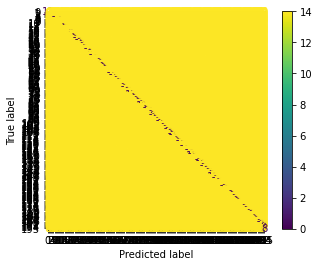

In [ ]:
class KNNClassifierModel(KNNClassifierModel):  
  def first_experiment(self,
                       training_set,
                       test_set,
                       num_of_neighbors_list):
    index_experiment = 1
    for num_of_neighbors in num_of_neighbors_list:
      self.BuildEncoder()
      self.AddKNNModel(num_of_neighbors)
      labels, encoder_predictions = self.PredictEncoderResults(training_set)
      self.Train(labels, encoder_predictions)

      labels, encoder_test_predictions = self.PredictEncoderResults(test_set)
      labels, predictions = self.PredictingTestResults(labels, encoder_test_predictions)
      self.ShowModelEvaluation(labels, predictions)

      self.SaveModel(f'/content/drive/MyDrive/Google Colab/Final Project Basics/KNN Classifier Model/Exp1/{index_experiment}')
      index_experiment += 1

transfer_learning_id = '1GlSxW6ANqfkao7lkc7vxXaGsTmIln8li'
transfer_learning_name = 'TLBestModel'
knn_model = KNNClassifierModel(transfer_learning_id, transfer_learning_name)
knn_model.first_experiment(cars_train, 
                           cars_test,
                           [5])

Show how the power affected on the model results

Downloading...

From: https://drive.google.com/uc?id=1GlSxW6ANqfkao7lkc7vxXaGsTmIln8li

To: /content/TLBestModel.zip

100%|██████████| 197M/197M [00:00<00:00, 255MB/s]


Streaming output truncated to the last 5000 lines.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0.], shape=(196,), dtype=float32)

[111]

tf.Tensor(

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

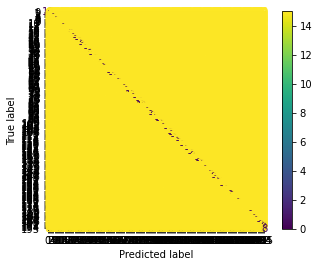

In [ ]:
class KNNClassifierModel(KNNClassifierModel):  
  def second_experiment(self,
                        training_set,
                        test_set,
                        power_list):
    index_experiment = 1
    for power in power_list:
      self.BuildEncoder()
      self.AddKNNModel(5, power)
      labels, encoder_predictions = self.PredictEncoderResults(cars_train)
      self.Train(labels, encoder_predictions)

      labels, encoder_test_predictions = self.PredictEncoderResults(cars_test)
      labels, predictions = self.PredictingTestResults(labels, encoder_test_predictions)
      self.ShowModelEvaluation(labels, predictions)

      self.SaveModel(f'/content/drive/MyDrive/Google Colab/Final Project Basics/KNN Classifier Model/Exp2/{index_experiment}')
      index_experiment += 1

transfer_learning_id = '1GlSxW6ANqfkao7lkc7vxXaGsTmIln8li'
transfer_learning_name = 'TLBestModel'
knn_model = KNNClassifierModel(transfer_learning_id, transfer_learning_name)
knn_model.second_experiment(cars_train, 
                            cars_test,
                            [3])

## Create a KNNClassifier object and training our model on the Training set

Downloading...

From: https://drive.google.com/uc?id=1GlSxW6ANqfkao7lkc7vxXaGsTmIln8li

To: /content/TLBestModel.zip

100%|██████████| 197M/197M [00:00<00:00, 289MB/s]


Streaming output truncated to the last 5000 lines.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0.], shape=(196,), dtype=float32)

[21]

tf.Tensor(

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

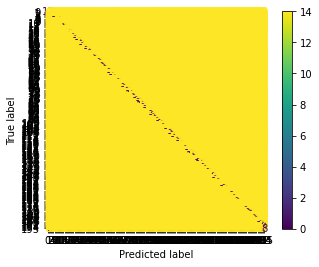

In [ ]:
knn_classifier_model = KNNClassifierModel('1GlSxW6ANqfkao7lkc7vxXaGsTmIln8li', 'TLBestModel')
knn_classifier_model.BestModelGenerate()
labels, encoder_predictions = knn_classifier_model.PredictEncoderResults(cars_train)
knn_classifier_model.Train(labels, encoder_predictions)
labels, encoder_test_predictions = knn_classifier_model.PredictEncoderResults(cars_test)
labels, predictions = knn_classifier_model.PredictingTestResults(labels, encoder_test_predictions)
knn_classifier_model.ShowModelEvaluation(labels, predictions)

knn_classifier_model.SaveModel('/content/drive/MyDrive/Google Colab/Final Project Basics/KNN Classifier Model/KnnBestModel')

## Making a single prediction

Downloading...
From: https://drive.google.com/uc?id=1GlSxW6ANqfkao7lkc7vxXaGsTmIln8li
To: /content/TLBestModel.zip
100%|██████████| 197M/197M [00:00<00:00, 280MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-8Yqp30L38VSZzTgAJojLYeYB83KBhSN
To: /content/KnnBestModel.pkl
100%|██████████| 359M/359M [00:01<00:00, 192MB/s]
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Saving 2012FRD003a_640_01.jpg to 2012FRD003a_640_01 (3).jpg
Saving chevy.jpg to chevy (3).jpg
1/1 [==============================] - 1s 678ms/step
[109.]
Name of class: Ford Edge SUV 2012


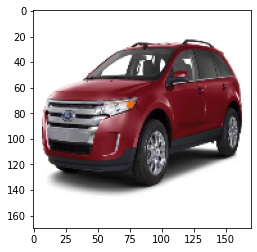

1/1 [==============================] - 0s 31ms/step
[65.]
Name of class: Chevrolet Cobalt SS 2010


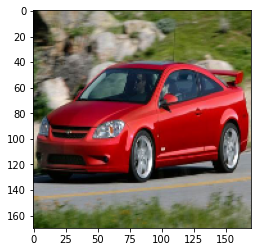

In [12]:
from google.colab import files
from PIL import Image

transfer_learning_id = '1GlSxW6ANqfkao7lkc7vxXaGsTmIln8li'
transfer_learning_name = 'TLBestModel'
transfer_learning_best_model = TransferLearningModel.LoadModel(transfer_learning_id, transfer_learning_name)
encoder = Model(inputs=transfer_learning_best_model.input, 
                outputs=transfer_learning_best_model.get_layer('flatten').output)

knn_id = '1-8Yqp30L38VSZzTgAJojLYeYB83KBhSN'
knn_name = 'KnnBestModel'
knn_best_model = KNNClassifierModel.LoadModel(knn_id, knn_name)

test_images = files.upload()
for imageName in test_images.keys():
    image = tf.cast(Image.open(imageName), tf.float32)
    image /= 255.0
    image = tf.image.resize(image, [INPUT_LENGTH, INPUT_WIDTH])
    image_signature = encoder.predict(np.expand_dims([image],axis=-1))
    result = knn_best_model.predict(image_signature)
    print(result)
    class_names = ds_info.features['label'].names
    print(f'Name of class: {class_names[int(result[0])]}') 
    plt.imshow(image)
    plt.show()

# End-to-End CNN

Create the base cnn model

In [13]:
class EndToEndCNN():
  def __init__(self):
    self.cnn = tf.keras.models.Sequential()
    self.callback = None

## Create function to add different types of layers

In [ ]:
class EndToEndCNN(EndToEndCNN):
  def AddInputLayer(self, numOfFilter, kernelSize, padding, activation, input_length, input_width):
    self.cnn.add(tf.keras.layers.Conv2D(filters=numOfFilter, padding=padding, kernel_size=kernelSize, activation=activation, input_shape=(input_length, input_width, 3)))
  def AddConv2DLayer(self, numOfFilter, kernelSize, padding, activation):
    self.cnn.add(tf.keras.layers.Conv2D(filters=numOfFilter, padding=padding, kernel_size=kernelSize, activation=activation))
  def AddMaxPooling2DLayer(self, pool_size=2, strides=2):
    self.cnn.add(tf.keras.layers.MaxPool2D(pool_size=pool_size, strides=strides))
  def AddDropoutLayer(self, dropout):
    self.cnn.add(tf.keras.layers.Dropout(dropout))
  def AddFlattenLayer(self):
    self.cnn.add(tf.keras.layers.Flatten())
  def AddDenseLayer(self, numOfNeurons, activation):
    self.cnn.add(tf.keras.layers.Dense(units=numOfNeurons, activation=activation))
  def SetCallback(self, callback):
    self.callback = callback

## Genrate the best

In [ ]:
class EndToEndCNN(EndToEndCNN):
  def BestModelGenerate(self):
    self.SetCallback(tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode = "max", patience=2))
    self.AddInputLayer(32, 3, "valid", "relu", INPUT_LENGTH, INPUT_WIDTH)
    self.AddMaxPooling2DLayer()
    self.AddDropoutLayer(0.2)
    #Adding 2nd Convolution and Pooling Layer
    self.AddConv2DLayer(32, 3, "valid", "relu")
    self.AddMaxPooling2DLayer()
    self.AddDropoutLayer(0.2)
    #Adding 3rd Convolution and Pooling Layer
    self.AddConv2DLayer(32, 3, "valid", "relu")
    self.AddMaxPooling2DLayer()
    self.AddDropoutLayer(0.2)
    #Adding 4th Convolution and Pooling Layer
    self.AddConv2DLayer(32, 3, "valid", "relu")
    self.AddMaxPooling2DLayer()
    self.AddDropoutLayer(0.2)
    #Adding 5th Convolution and Pooling Layer
    self.AddConv2DLayer(32, 3, "valid", "relu")
    self.AddMaxPooling2DLayer()
    self.AddDropoutLayer(0.2)

    #Flatten
    self.AddFlattenLayer()

    #Adding Input and Output Layer
    self.AddDenseLayer(256, 'relu')
    self.AddDenseLayer(256, 'relu')
    self.AddDenseLayer(256, 'relu')
    self.AddDenseLayer(196, 'softmax')

## Compiling the model
Now a model has been created based on our architecture 🏆

In [ ]:
class EndToEndCNN(EndToEndCNN):  
  def Compile(self, learning_rate=0.001):
    self.cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

## Training our model on the Training set

In [ ]:
class EndToEndCNN(EndToEndCNN):  
  def Train(self, batch_size, num_of_epoch, training_set, test_Set):
    self.history = self.cnn.fit(training_set.batch(batch_size), validation_data=test_Set.batch(batch_size), batch_size=batch_size, epochs=num_of_epoch, callback=[self.callback])

## Model Results
Predicting test result according to label and prediction

In [ ]:
class EndToEndCNN(EndToEndCNN):
  def PredictingTestResults(self, test_set):
    predictions = np.array([]) 
    labels =  np.array([])

    num_of_cars = test_set.cardinality().numpy()
    cars_it = test_set.as_numpy_iterator()
    for car_index in range(num_of_cars):
      image, label = cars_it.next()
      prediction = self.cnn.predict(np.expand_dims([image],axis=-1))
      predictions = np.concatenate([predictions, [prediction.argmax()]])
      labels = np.concatenate([labels,[label.argmax()]])

    return labels, predictions

## Model Performance Evaluation

### Visualization of the Loss training VS validation

In [ ]:
class EndToEndCNN(EndToEndCNN):
  def ShowLossTrainingVsValidation(self):
    from matplotlib import pyplot as plt
    plt.plot(self.history.history['loss'])
    plt.plot(self.history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### Visualization of the Accuracy training VS validation

In [ ]:
class EndToEndCNN(EndToEndCNN):
  def ShowAccuracyTrainingVsValidation(self):
    from matplotlib import pyplot as plt
    plt.plot(self.history.history['accuracy'])
    plt.plot(self.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### Visualization of the Accuracy Score

In [ ]:
class EndToEndCNN(EndToEndCNN):
  def PrintAccuracyScore(self, labels, predictions):
    from sklearn.metrics import accuracy_score

    accuracy = accuracy_score(labels, predictions)
    print(f'Accuracy: {round(accuracy*100)}%')

### Printing the confusion matrix

In [ ]:
class EndToEndCNN(EndToEndCNN):
  def PrintConfusionMatrix(self, labels, predictions):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(labels, predictions)
    print(f'Confusion Matrix:\n\n{cm}')

    return cm

In [ ]:
class EndToEndCNN(EndToEndCNN):
  def PrintConfusionmatrixaAsTable(self, labels, predictions):
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(labels, predictions)
    cmd = ConfusionMatrixDisplay(cm, display_labels=None)
    cmd.plot()

### Visualization of the Balanced Accuracy Score

In [ ]:
class EndToEndCNN(EndToEndCNN):
  def PrintBalancedAccuracyScore(self, labels, predictions):
    from sklearn.metrics import balanced_accuracy_score
    
    bal_acc = balanced_accuracy_score(labels, predictions)
    print(f'Balanced Accuracy: {round(bal_acc*100)}%')

### Show Classification Report

In [ ]:
class EndToEndCNN(EndToEndCNN):
  def PrintClassificationReport(self, labels, predictions):
    from sklearn.metrics import classification_report
    print(classification_report(labels, predictions, labels=list(range(0,NUM_OF_CLASSES)), target_names=ds_info.features['label'].names))

## Show all model metrics

In [ ]:
class EndToEndCNN(EndToEndCNN):
  def ShowModelEvaluation(self, labels, predictions):
    self.ShowLossTrainingVsValidation()
    self.ShowAccuracyTrainingVsValidation()
    self.PrintConfusionMatrix(labels, predictions)
    self.PrintConfusionmatrixaAsTable(labels, predictions)
    self.PrintAccuracyScore(labels, predictions)
    self.PrintBalancedAccuracyScore(labels, predictions)
    self.PrintClassificationReport(labels, predictions)

## Save the model

In [ ]:
class EndToEndCNN(EndToEndCNN):  
  def SaveModel(self, path):
    from google.colab import drive
    drive.mount('/content/drive')
    self.cnn.save(path)

## Load the end to end CNN model

In [14]:
class EndToEndCNN(EndToEndCNN):
  @staticmethod
  def LoadModel(id, name):
    import gdown
    from zipfile import ZipFile
    gdown.download(id=id, output=f'/content/{name}.zip', quiet=False)
    
    zf = ZipFile(f'/content/{name}.zip', 'r')
    zf.extractall('/content/')
    zf.close()

    return tf.keras.models.load_model(f'/content/{name}')

## Experiments

Show how the number of layers and number of neurons in layer affected on the model results

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 168, 168, 32)      896       

                                                                 

 max_pooling2d (MaxPooling2D  (None, 84, 84, 32)       0         

 )                                                               

                                                                 

 conv2d_1 (Conv2D)           (None, 82, 82, 32)        9248      

                                                                 

 max_pooling2d_1 (MaxPooling  (None, 41, 41, 32)       0         

 2D)                                                             

                                                                 

 conv2d_2 (Conv2D)           (None, 39, 39, 16)        4624      

                                                                 

 max_pooling2d_2 (MaxPooling  (None, 19,

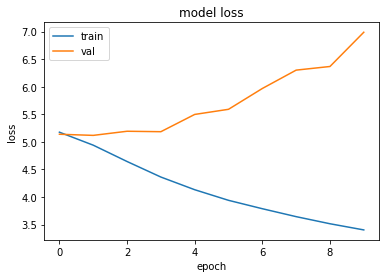

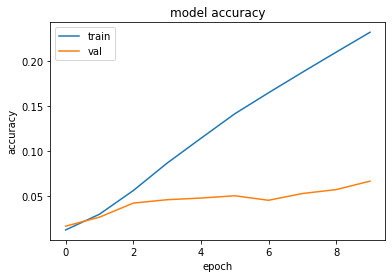

Confusion Matrix:



[[2 0 0 ... 0 0 0]

 [0 0 0 ... 0 0 0]

 [0 0 1 ... 0 0 1]

 ...

 [0 0 0 ... 0 0 0]

 [0 0 0 ... 0 0 0]

 [0 0 0 ... 0 0 2]]

Accuracy: 6%

Balanced Accuracy: 6%

                                                        precision    recall  f1-score   support



                            AM General Hummer SUV 2000       0.17      0.17      0.17        12

                                   Acura RL Sedan 2012       0.00      0.00      0.00         5

                                   Acura TL Sedan 2012       0.17      0.20      0.18         5

                                  Acura TL Type-S 2008       0.00      0.00      0.00         8

                                  Acura TSX Sedan 2012       0.00      0.00      0.00         6

                             Acura Integra Type R 2001       0.14      0.10      0.12        10

                              Acura ZDX Hatchback 2012       0.00      0.00      0.00         7

              Aston Martin V8 Vantage

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


Mounted at /content/drive


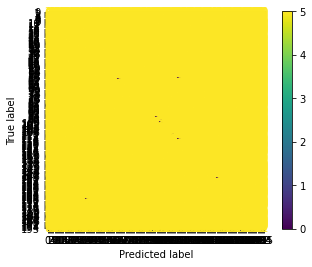

In [ ]:
class EndToEndCNN(EndToEndCNN):  
  def first_experiment(self,
                       training_set,
                       test_set,
                       convolutional_layers_list,
                       fully_connected_layers_list,
                       neurons_in_layer_list,
                       filter_size_in_layer_list):
    index_experiment = 1
    for convolutional_layer in convolutional_layers_list:
        for fully_connected_layer in fully_connected_layers_list:
          for neuron_in_layer in neurons_in_layer_list:
            for filter_size_in_layer in filter_size_in_layer_list:

              self.AddInputLayer(filter_size_in_layer, 3, 'valid', 'relu', INPUT_LENGTH, INPUT_WIDTH)
              self.AddMaxPooling2DLayer()

              filters = filter_size_in_layer
              for con_layer in range(convolutional_layer):
                self.AddConv2DLayer(filters, 3, 'valid', 'relu')
                self.AddMaxPooling2DLayer()
                filters = filters // 2
              
              self.AddFlattenLayer()

              units = neuron_in_layer
              for fully_con_layer in range(fully_connected_layer):
                self.AddDenseLayer(units, 'relu')
                units = units // 2

              self.AddDenseLayer(NUM_OF_CLASSES, 'softmax')

              self.cnn.summary()

              self.Compile()
              self.Train(BATCH_SIZE, NUM_OF_EPOCHS, training_set, test_set)

              labels, predictions = self.PredictingTestResults(test_set)
              self.ShowModelEvaluation(labels, predictions)

              self.SaveModel(f'/content/drive/MyDrive/Google Colab/Final Project Basics/CNN/Exp1/{index_experiment}')
              index_experiment += 1

cnn_model = EndToEndCNN()
cnn_model.first_experiment(cars_train, 
                           cars_test,
                           [3],
                           [2],
                           [80],
                           [32])

Show how the learning rate and batch size and number of epohcs affected on the model results

Epoch 1/5

1094/1094 [==============================] - 343s 288ms/step - loss: 5.1224 - accuracy: 0.0158 - val_loss: 4.9647 - val_accuracy: 0.0312

Epoch 2/5

1094/1094 [==============================] - 282s 247ms/step - loss: 4.6310 - accuracy: 0.0603 - val_loss: 4.8262 - val_accuracy: 0.0619

Epoch 3/5

1094/1094 [==============================] - 370s 328ms/step - loss: 3.9025 - accuracy: 0.1612 - val_loss: 5.0094 - val_accuracy: 0.0806

Epoch 4/5

1094/1094 [==============================] - 300s 262ms/step - loss: 3.1674 - accuracy: 0.2927 - val_loss: 5.9473 - val_accuracy: 0.0812

Epoch 5/5

1094/1094 [==============================] - 333s 293ms/step - loss: 2.5931 - accuracy: 0.4079 - val_loss: 6.7621 - val_accuracy: 0.0906

1/1 [==============================] - 1s 635ms/step

1/1 [==============================] - 0s 23ms/step

1/1 [==============================] - 0s 51ms/step

1/1 [==============================] - 0s 25ms/step

1/1 [==============================] - 0s 

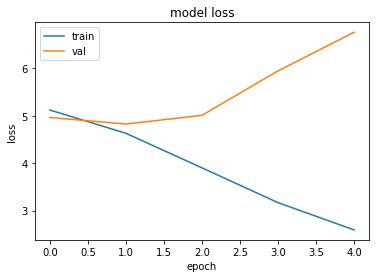

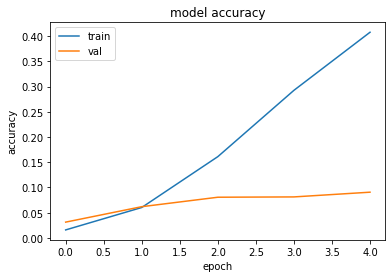

Confusion Matrix:



[[1 0 0 ... 0 0 0]

 [0 1 0 ... 0 1 0]

 [0 0 0 ... 0 0 0]

 ...

 [0 0 0 ... 2 0 0]

 [0 0 0 ... 0 3 0]

 [0 0 0 ... 0 0 2]]

Accuracy: 10%

Balanced Accuracy: 10%

                                                        precision    recall  f1-score   support



                            AM General Hummer SUV 2000       0.14      0.08      0.11        12

                                   Acura RL Sedan 2012       0.12      0.20      0.15         5

                                   Acura TL Sedan 2012       0.00      0.00      0.00         5

                                  Acura TL Type-S 2008       0.10      0.12      0.11         8

                                  Acura TSX Sedan 2012       0.14      0.17      0.15         6

                             Acura Integra Type R 2001       0.19      0.27      0.22        11

                              Acura ZDX Hatchback 2012       0.00      0.00      0.00         7

              Aston Martin V8 Vanta

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


Mounted at /content/drive


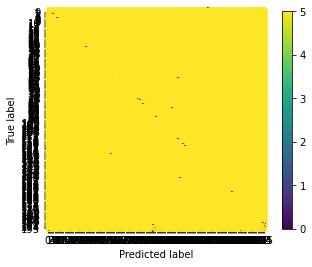

In [ ]:
class EndToEndCNN(EndToEndCNN):  
  def second_experiment(self,
                        training_set,
                        test_set,
                        learning_rates,
                        batch_sizes,
                        numbers_of_epochs):
    
    index_experiment = 1
    for learning_rate in learning_rates:
      for batch_size in batch_sizes:
        for numbers_of_epoch in numbers_of_epochs:
          self.BestModelGenerate()
          
          self.Compile(learning_rate)
          self.Train(batch_size, numbers_of_epoch, training_set, test_set)

          labels, predictions = self.PredictingTestResults(test_set)
          self.ShowModelEvaluation(labels, predictions)

          self.SaveModel(f'/content/drive/MyDrive/Google Colab/Final Project Basics/CNN/Exp2/{index_experiment}')
          index_experiment += 1

cnn_model = EndToEndCNN()
cnn_model.second_experiment(cars_train, 
                            cars_test,
                            [0.001],
                            [40],
                            [5])

## Create a End To End CNN object and training our model on the Training set

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 168, 168, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 84, 84, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 84, 84, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 82, 82, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 41, 41, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 41, 41, 32)       

2023-03-12 21:03:55.977139: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1368/1368 [==============================] - 269s 185ms/step - loss: 5.2764 - accuracy: 0.0082 - val_loss: 5.2795 - val_accuracy: 0.0081
Epoch 2/30
1368/1368 [==============================] - 262s 183ms/step - loss: 5.1953 - accuracy: 0.0112 - val_loss: 5.1444 - val_accuracy: 0.0094
Epoch 3/30
1368/1368 [==============================] - 259s 181ms/step - loss: 5.0792 - accuracy: 0.0158 - val_loss: 4.9643 - val_accuracy: 0.0244
Epoch 4/30
1368/1368 [==============================] - 264s 184ms/step - loss: 4.8878 - accuracy: 0.0273 - val_loss: 4.8449 - val_accuracy: 0.0294
Epoch 5/30
1368/1368 [==============================] - 266s 185ms/step - loss: 4.7166 - accuracy: 0.0386 - val_loss: 4.6926 - val_accuracy: 0.0356
Epoch 6/30
1368/1368 [==============================] - 261s 182ms/step - loss: 4.5466 - accuracy: 0.0526 - val_loss: 4.5059 - val_accuracy: 0.0494
Epoch 7/30
1368/1368 [==============================] - 262s 182ms/step - loss: 4.3877 - accuracy: 0.0688 - val_loss: 4.432

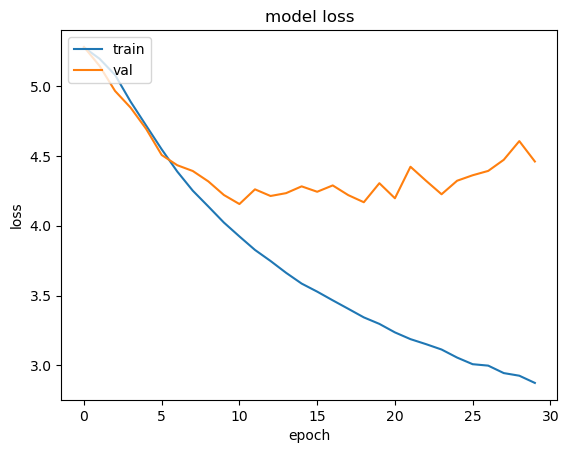

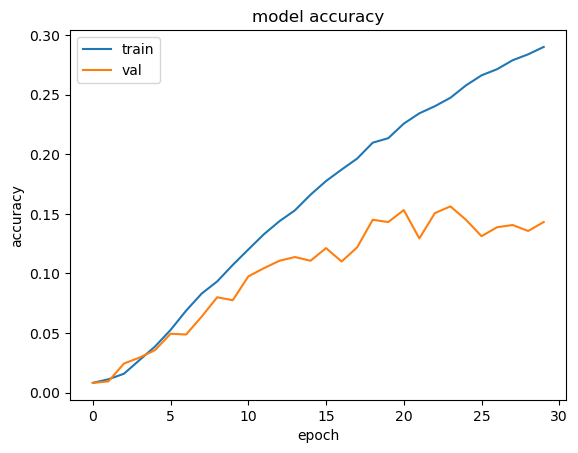

Confusion Matrix:

[[2 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 0 2]]
Accuracy: 14%
Balanced Accuracy: 15%
                                                        precision    recall  f1-score   support

                            AM General Hummer SUV 2000       0.33      0.18      0.24        11
                                   Acura RL Sedan 2012       0.00      0.00      0.00         5
                                   Acura TL Sedan 2012       0.00      0.00      0.00         5
                                  Acura TL Type-S 2008       0.00      0.00      0.00         8
                                  Acura TSX Sedan 2012       0.29      0.40      0.33         5
                             Acura Integra Type R 2001       0.00      0.00      0.00        10
                              Acura ZDX Hatchback 2012       0.00      0.00      0.00         7
              Aston Martin V8 Vantage Convertible 2012 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


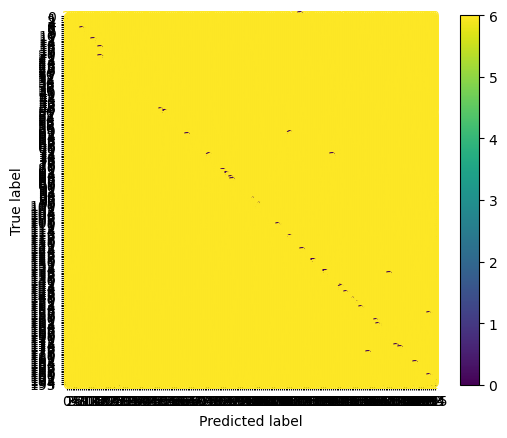

In [ ]:
end_to_end_cnn = EndToEndCNN()
end_to_end_cnn.BestModelGenerate()
end_to_end_cnn.cnn.summary()
end_to_end_cnn.Compile(LEARNING_RATE)
end_to_end_cnn.Train(32, 30, cars_train, cars_test)
labels, predictions = end_to_end_cnn.PredictingTestResults(cars_test)
end_to_end_cnn.ShowModelEvaluation(labels, predictions)
end_to_end_cnn.SaveModel('/content/drive/MyDrive/Google Colab/Final Project Basics/CNN/CnnBestModel')


## Making a single prediction

Downloading...
From: https://drive.google.com/uc?id=1vc21e3NT4II9bvHfyyfrDuDIFnsWdU5P
To: /content/CnnBestModel.zip
100%|██████████| 3.17M/3.17M [00:00<00:00, 164MB/s]


Saving 2007_hyundai_elantra_angularfront.jpg to 2007_hyundai_elantra_angularfront.jpg
Saving 6256ce19-cf54-4fe9-a40d-8f2667d520f3.jpg to 6256ce19-cf54-4fe9-a40d-8f2667d520f3.jpg
1/1 [==============================] - 0s 102ms/step
Name of class: Hyundai Sonata Hybrid Sedan 2012


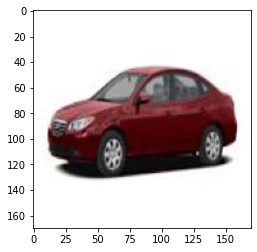

1/1 [==============================] - 0s 22ms/step
Name of class: Dodge Caliber Wagon 2007


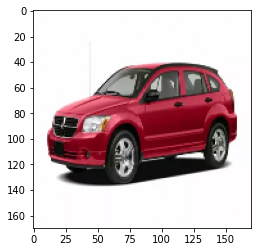

In [17]:
from google.colab import files
from PIL import Image

cnn_id = '1vc21e3NT4II9bvHfyyfrDuDIFnsWdU5P'
cnn_name = 'CnnBestModel'
cnn_best_model = EndToEndCNN.LoadModel(cnn_id, cnn_name)

test_images = files.upload()
for imageName in test_images.keys():
    image = tf.cast(Image.open(imageName), tf.float32)
    image /= 255.0
    image = tf.image.resize(image, [INPUT_LENGTH, INPUT_WIDTH])
    result = cnn_best_model.predict(np.expand_dims([image],axis=-1))
    class_names = ds_info.features['label'].names
    print(f'Name of class: {class_names[np.argmax(result[0], axis=-1)]}') 
    plt.imshow(image)
    plt.show()